In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

TRAINING_FILE = "train.csv"
TESTING_FILE = "test.csv"
AGE_FILLER_LOGIC = False

def load_data(file, header=True):
    csv_path = os.path.join("", file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)


data = load_data(TRAINING_FILE)
test_data = load_data(TESTING_FILE)
datacopy = data.copy()

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

def age_filler(data, test_data):
    agedata = data.copy()
    test_agedata = test_data.copy()
    
    agedata.drop("Survived", axis=1, inplace=True)
    sex_encoder = LabelBinarizer()
    sex_encoder.fit(agedata["Sex"])
        
    for set in (agedata, test_agedata):
        set.drop("Name", axis=1, inplace=True)
        set.drop("Ticket", axis=1, inplace=True)
        set.drop("Cabin", axis=1, inplace=True)
        set.drop("Embarked", axis=1, inplace=True)
        set["Gender"] = sex_encoder.transform(set["Sex"])
        set.drop("Sex", axis=1, inplace=True)

    X_ = agedata[agedata["Age"].notnull()]
    Y = X_["Age"].values
    X_ = X_.drop("Age", axis=1)
    X_ = X_.drop("PassengerId", axis=1)
    X = X_[list(X_)].values
    scalar = StandardScaler()
    scalar.fit(X)
    X = pd.DataFrame(scalar.transform(X), columns=X_.columns)
    
    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(X, Y)

    dfs = []
    for set in (agedata, test_agedata):
        test_X_ = set[set["Age"].isnull()]
        ids = test_X_["PassengerId"].copy()
        test_X_ = test_X_.drop("Age", axis=1)
        test_X_ = test_X_.drop("PassengerId", axis=1)
        test_X = test_X_[list(test_X_)].values
        test_X = pd.DataFrame(scalar.transform(test_X), columns=test_X_.columns)

        test_Y = tree_reg.predict(test_X)
    
        df = pd.DataFrame(columns=["PassengerId", "Age_new"])
        df["PassengerId"] = ids.values
        df["Age_new"] = test_Y
        dfs.append(df)
        
    return dfs

dfs = age_filler(data, test_data)

In [3]:
data.drop("Name", axis=1, inplace=True)
data.drop("Ticket", axis=1, inplace=True)
test_data.drop("Name", axis=1, inplace=True)
test_data.drop("Ticket", axis=1, inplace=True)

In [4]:
df_train = dfs[0]
data = pd.merge(left=data, right=df_train, how='left', on='PassengerId')

if not AGE_FILLER_LOGIC:
    data["Age_new"].fillna(0, inplace=True)
    data["Age"].fillna(0, inplace=True)
    data["Age"] = data["Age_new"] + data["Age"]
else:
    data["Age"].fillna(data["Age"].median(), inplace=True)
    
data.drop("Age_new", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 76.6+ KB


In [5]:
df_test = dfs[1]
test_data = pd.merge(left=test_data, right=df_test, how='left', on='PassengerId')

if not AGE_FILLER_LOGIC:
    test_data["Age_new"].fillna(0, inplace=True)
    test_data["Age"].fillna(0, inplace=True)
    test_data["Age"] = test_data["Age_new"] + test_data["Age"]
else:
    test_data["Age"].fillna(data["Age"].median(), inplace=True)
    
test_data.drop("Age_new", axis=1, inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 32.7+ KB


In [6]:
data["Fare"].fillna(data["Fare"].median(), inplace=True)
test_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 76.6+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 32.7+ KB


In [9]:
data[data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,62,1,1,female,38.0,0,0,80.0,B28,NaN
829,830,1,1,female,62.0,0,0,80.0,B28,NaN


In [10]:
data["Embarked"].fillna("C", inplace=True)
test_data["Embarked"].fillna("C", inplace=True)

In [11]:
data["Fare_Per_Age"] = data["Fare"] / data["Age"]
test_data["Fare_Per_Age"] = test_data["Fare"] / test_data["Age"]

In [12]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Fare_Per_Age
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,0.329545
1,2,1,1,female,38.0,1,0,71.2833,C85,C,1.875876
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,0.304808
3,4,1,1,female,35.0,1,0,53.1000,C123,S,1.517143
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,0.230000


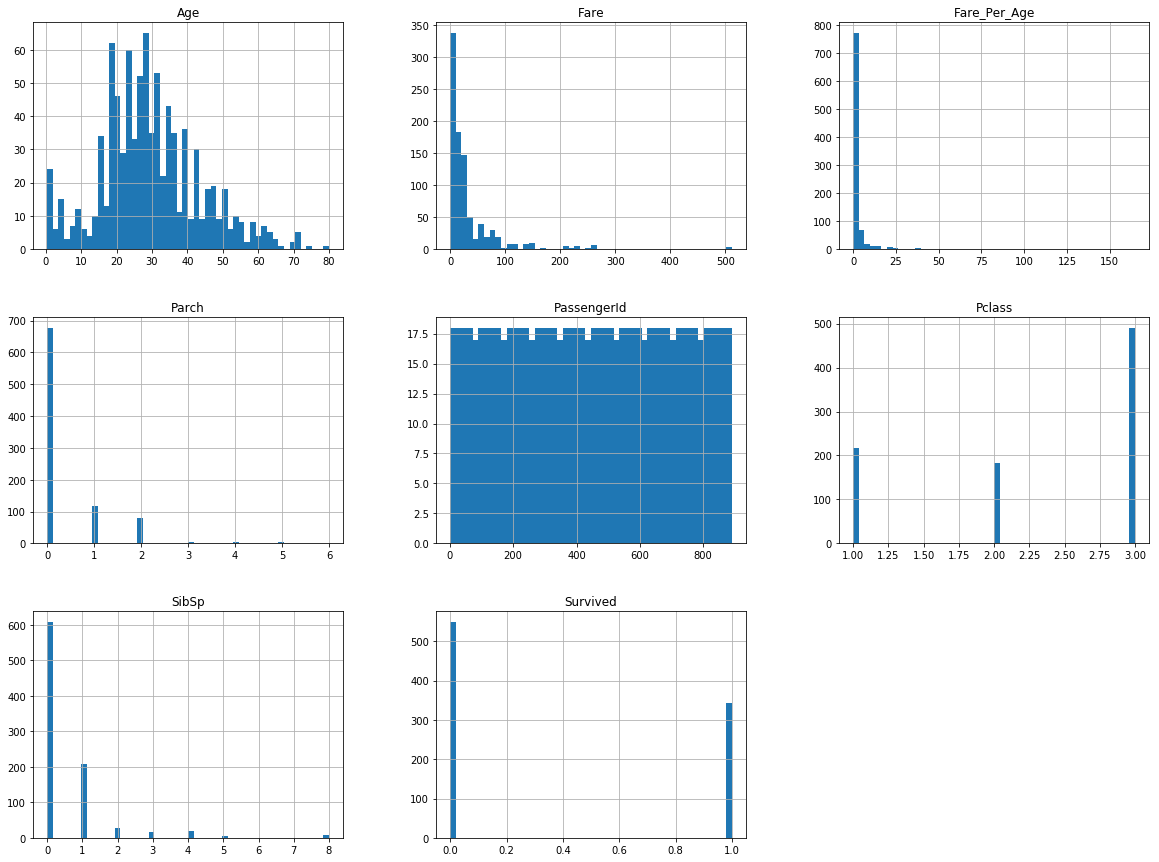

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
data["Cabin"].fillna("Z", inplace=True)
data["Chamber"] = [x[0] for x in data["Cabin"]]
data.drop("Cabin", axis=1, inplace=True)

In [15]:
test_data["Cabin"].fillna("Z", inplace=True)
test_data["Chamber"] = [x[0] for x in test_data["Cabin"]]
test_data.drop("Cabin", axis=1, inplace=True)

In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Sex             418 non-null object
Age             418 non-null float64
SibSp           418 non-null int64
Parch           418 non-null int64
Fare            418 non-null float64
Embarked        418 non-null object
Fare_Per_Age    418 non-null float64
Chamber         418 non-null object
dtypes: float64(3), int64(4), object(3)
memory usage: 35.9+ KB


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Sex             891 non-null object
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Embarked        891 non-null object
Fare_Per_Age    891 non-null float64
Chamber         891 non-null object
dtypes: float64(3), int64(5), object(3)
memory usage: 83.5+ KB


In [18]:
label = data["Survived"].copy()
data.drop("Survived", axis=1, inplace=True)

In [19]:
ids = data["PassengerId"].copy()
data.drop("PassengerId", axis=1, inplace=True)
ids_test = test_data["PassengerId"].copy()
test_data.drop("PassengerId", axis=1, inplace=True)

In [20]:
sex_encoder = LabelBinarizer()
sex_encoder.fit(data["Sex"])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [21]:
data["Gender"] = sex_encoder.transform(data["Sex"])
data.drop("Sex", axis=1, inplace=True)
test_data["Gender"] = sex_encoder.transform(test_data["Sex"])
test_data.drop("Sex", axis=1, inplace=True)

In [22]:
data.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Fare_Per_Age,Chamber,Gender
0,3,22.0,1,0,7.2500,S,0.329545,Z,1
1,1,38.0,1,0,71.2833,C,1.875876,C,0
2,3,26.0,0,0,7.9250,S,0.304808,Z,0
3,1,35.0,1,0,53.1000,S,1.517143,C,0
4,3,35.0,0,0,8.0500,S,0.230000,Z,1


In [23]:
test_data.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Fare_Per_Age,Chamber,Gender
0,3,34.5,0,0,7.8292,Q,0.226933,Z,1
1,3,47.0,1,0,7.0000,S,0.148936,Z,0
2,2,62.0,0,0,9.6875,Q,0.156250,Z,1
3,3,27.0,0,0,8.6625,S,0.320833,Z,1
4,3,22.0,1,1,12.2875,S,0.558523,Z,0


In [24]:
data_Chamber = data["Chamber"]
test_data_Chamber = test_data["Chamber"]
chamber_encoder = LabelBinarizer()
chamber_encoder.fit(data_Chamber)
data.drop("Chamber", axis=1, inplace=True)
test_data.drop("Chamber", axis=1, inplace=True)

In [25]:
data_Embarked = data["Embarked"]
test_data_Embarked = test_data["Embarked"]
embarked_encoder = LabelBinarizer()
embarked_encoder.fit(data_Embarked)
data.drop("Embarked", axis=1, inplace=True)
test_data.drop("Embarked", axis=1, inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass          891 non-null int64
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Fare_Per_Age    891 non-null float64
Gender          891 non-null int64
dtypes: float64(3), int64(4)
memory usage: 95.7 KB


In [27]:
data.head()

,Pclass,Age,SibSp,Parch,Fare,Fare_Per_Age,Gender
0,3,22.0,1,0,7.2500,0.329545,1
1,1,38.0,1,0,71.2833,1.875876,0
2,3,26.0,0,0,7.9250,0.304808,0
3,1,35.0,1,0,53.1000,1.517143,0
4,3,35.0,0,0,8.0500,0.230000,1


In [28]:
features = data[list(data)].values

In [29]:
features = np.concatenate((features, embarked_encoder.transform(data_Embarked)), axis=1)
features = np.concatenate((features, chamber_encoder.transform(data_Chamber)), axis=1)

In [30]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputer.fit(features)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [31]:
features = imputer.transform(features)

In [32]:
scalar = StandardScaler()
scalar.fit(features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [33]:
features = scalar.transform(features)

In [34]:
test_features = test_data[list(test_data)].values
test_features = np.concatenate((test_features, embarked_encoder.transform(test_data_Embarked)), axis=1)
test_features = np.concatenate((test_features, chamber_encoder.transform(test_data_Chamber)), axis=1)
np.shape(test_features)

(418, 19)

In [35]:
test_features = imputer.transform(test_features)

In [36]:
test_features = scalar.transform(test_features)

In [37]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.metrics import accuracy_score

sgd_clf = SGDClassifier(random_state=42, penalty='l1')
print("\nCross Val Scores on training set: ", cross_val_score(clone(sgd_clf), features, label, cv=3, scoring="accuracy"))

scores = cross_val_score(clone(sgd_clf), features, label, scoring="neg_mean_squared_error", cv=3)
rmse_scores = np.sqrt(-scores)
print("\nMean", rmse_scores.mean())
print("SD", rmse_scores.std())

sgd_clf.fit(features, label)
label_pred = cross_val_predict(clone(sgd_clf), features, label, cv=3)
print("\n\nAccuracy on testing data set\n", accuracy_score(label, label_pred))

predictions_sgd = sgd_clf.predict(test_features)


Cross Val Scores on training set:  [0.54208754 0.72727273 0.79124579]

Mean 0.5519405125529082
SD 0.09215738567334766


Accuracy on testing data set
 0.6868686868686869


In [38]:
# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier(algorithm='auto')
print("Cross Val Scores on training set\n", cross_val_score(clone(knn_clf), features, label, cv=3, scoring="accuracy"))

scores = cross_val_score(clone(knn_clf), features, label, scoring="neg_mean_squared_error", cv=3)
rmse_scores = np.sqrt(-scores)
print("\nMean", rmse_scores.mean())
print("SD", rmse_scores.std())

knn_clf.fit(features, label)
label_pred = cross_val_predict(clone(knn_clf), features, label, cv=3)
print("\n\nAccuracy on testing data set\n", accuracy_score(label, label_pred))

predictions_knn = knn_clf.predict(test_features)

Cross Val Scores on training set
 [0.77777778 0.78114478 0.81144781]

Mean 0.4578167097183809
SD 0.016745253432309707


Accuracy on testing data set
 0.7901234567901234


In [39]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.metrics import accuracy_score


forest_clf = RandomForestClassifier(random_state=42)
print("Cross Val Scores on training set\n", cross_val_score(clone(forest_clf), features, label, cv=3, scoring="accuracy"))

scores = cross_val_score(clone(forest_clf), features, label, scoring="neg_mean_squared_error", cv=3)
rmse_scores = np.sqrt(-scores)
print("\nMean", rmse_scores.mean())
print("SD", rmse_scores.std())

forest_clf.fit(features, label)
label_pred = cross_val_predict(clone(forest_clf), features, label, cv=3)
print("\n\nAccuracy on testing data set\n", accuracy_score(label, label_pred))

predictions_forest = forest_clf.predict(test_features)

Cross Val Scores on training set
 [0.79461279 0.78114478 0.8047138 ]

Mean 0.4543094241226986
SD 0.0106059886939022


Accuracy on testing data set
 0.7934904601571269


In [40]:
# MLP Classifier
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer

from keras.utils import to_categorical
label_binary = to_categorical(label)

batch_size = 50
num_classes = label_binary.shape[1]
epochs = 20
input_size = features.shape[1]

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(input_size,)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

adam = Adam(decay=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

history = model.fit(
                    features, 
                    label_binary,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(features, label_binary))

predictions_mlp = np.array(model.predict(test_features)).argmax(axis=1)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              20480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 1,072,130
Trainable params: 1,072,130
Non-trainable params: 0
_________________________________________________________________
Train on 891 samples, validate on 891 samples
Epoch 1/20
891/891 [==============================] - 1s 889us/step - loss: 0.5111 - a

In [41]:
test_label = predictions_knn

In [42]:
df_result = pd.DataFrame(columns=["PassengerId", "Survived"])
df_result["PassengerId"] = ids_test.values
df_result["Survived"] = test_label

In [43]:
df_result.to_csv("results.csv", encoding='utf-8', index=False)

In [44]:
df_result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
